## DATA PREPARATION

In [223]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy

pd.set_option('display.max_rows', 30)

In [224]:
# e.g. results/fidelity_eval_20_fps_substepping_1.json
path = "results/fidelity*.json"

data = []

for file_path in glob.glob(path):
    with open(file_path, "r") as f:
        file_path = file_path.replace(".json", "")

        # first int is fps second is substepping bool
        fps, substepping = [int(value)
                            for value in file_path.split("_") if value.isdigit()]

        # print(f"{fps = }, {bool(substepping) = }")

        content = json.load(f)
        labels = content['labels']
        values = map(float, content['values'])
        data.append({

            'fps': fps,
            'substepping': bool(substepping),
            # **dict(zip(labels, values)),
            'records': content['_checkpoint']['records']
        })


df = pd.DataFrame(data)

In [225]:
# df

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fps          8 non-null      int64 
 1   substepping  8 non-null      bool  
 2   records      8 non-null      object
dtypes: bool(1), int64(1), object(1)
memory usage: 268.0+ bytes


In [227]:
df = df.explode('records', ignore_index=True)
# pd.json_normalize(df['records'])
# df

In [228]:
record_df = pd.json_normalize(df['records'])
# record_df

In [229]:
# concatonate records data
df = pd.concat([df, record_df],  axis=1)

# drop original column
df = df.drop('records', axis=1)

# drop infractions columns

# remove prefices from column name
df.columns = df.columns.str.removeprefix('meta.')
df.columns = df.columns.str.removeprefix('scores.')
df = df.rename(columns={"index": "route_index"})

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   fps                                80 non-null     int64  
 1   substepping                        80 non-null     bool   
 2   route_index                        80 non-null     int64  
 3   route_id                           80 non-null     object 
 4   status                             80 non-null     object 
 5   infractions.collisions_layout      80 non-null     object 
 6   infractions.collisions_pedestrian  80 non-null     object 
 7   infractions.collisions_vehicle     80 non-null     object 
 8   infractions.outside_route_lanes    80 non-null     object 
 9   infractions.red_light              80 non-null     object 
 10  infractions.route_dev              80 non-null     object 
 11  infractions.route_timeout          80 non-null     object 
 

In [231]:
interesting_columns = ['fps', 'substepping',
                       'route_index', 'route_id', 'status', 'duration_game', 'duration_system', 'route_length', 'score_composed', 'score_penalty', 'score_route']
df = df[interesting_columns]

# df

In [232]:
df = df.set_index(['fps', 'substepping', 'route_index']).sort_index()
df

route_id                      status  \
fps substepping route_index                                                 
5   False       0            RouteScenario_16  Failed - Agent got blocked   
                1            RouteScenario_17                   Completed   
                2            RouteScenario_18  Failed - Agent got blocked   
                3            RouteScenario_19    Failed - Agent timed out   
                4            RouteScenario_20  Failed - Agent got blocked   
...                                       ...                         ...   
20  True        5            RouteScenario_21                   Completed   
                6            RouteScenario_22    Failed - Agent timed out   
                7            RouteScenario_23    Failed - Agent timed out   
                8            RouteScenario_24    Failed - Agent timed out   
                9            RouteScenario_25    Failed - Agent timed out   

                             duration_game  duration_system  route_length  \
fps substepping route_index                                                 
5   False       0               282.000004       367.187565   1071.028134   
                1               598.600009       782.648368    862.430089   
                2               295.800004       402.822112   1018.154809   
                3              1348.200020      1677.685935   1651.124043   
                4               407.400006       508.381444   1247.524779   
...                                    ...              ...           ...   
20  True        5               344.750005       900.105147    531.077514   
                6               851.050013      2146.905721    991.758808   
                7              1067.050016      2865.341363   1271.907966   
                8              1792.050027      4914.700573   2101.202735   
                9              1321.050020      3418.701327   1554.578340   

                             score_composed  score_penalty  score_route  
fps substepping route_index                                              
5   False       0                  2.339751         1.0000     2.339751  
                1                100.000000         1.0000   100.000000  
                2                 13.619493         1.0000    13.619493  
                3                 88.420179         1.0000    88.420179  
                4                 38.593606         1.0000    38.593606  
...                                     ...            ...          ...  
20  True        5                 70.000000         0.7000   100.000000  
                6                  8.667360         0.6000    14.445601  
                7                  7.994137         0.1512    52.871277  
                8                 27.136517         0.4200    64.610755  
                9                 16.250418         0.1800    90.280102  

[80 rows x 8 columns]

## Q1: How does fidelity settings affect execution time

/tmp/ipykernel_8217/581488258.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(column=['duration_system', 'duration_game'],


Text(0.5, 1.0, 'Game time [s]')

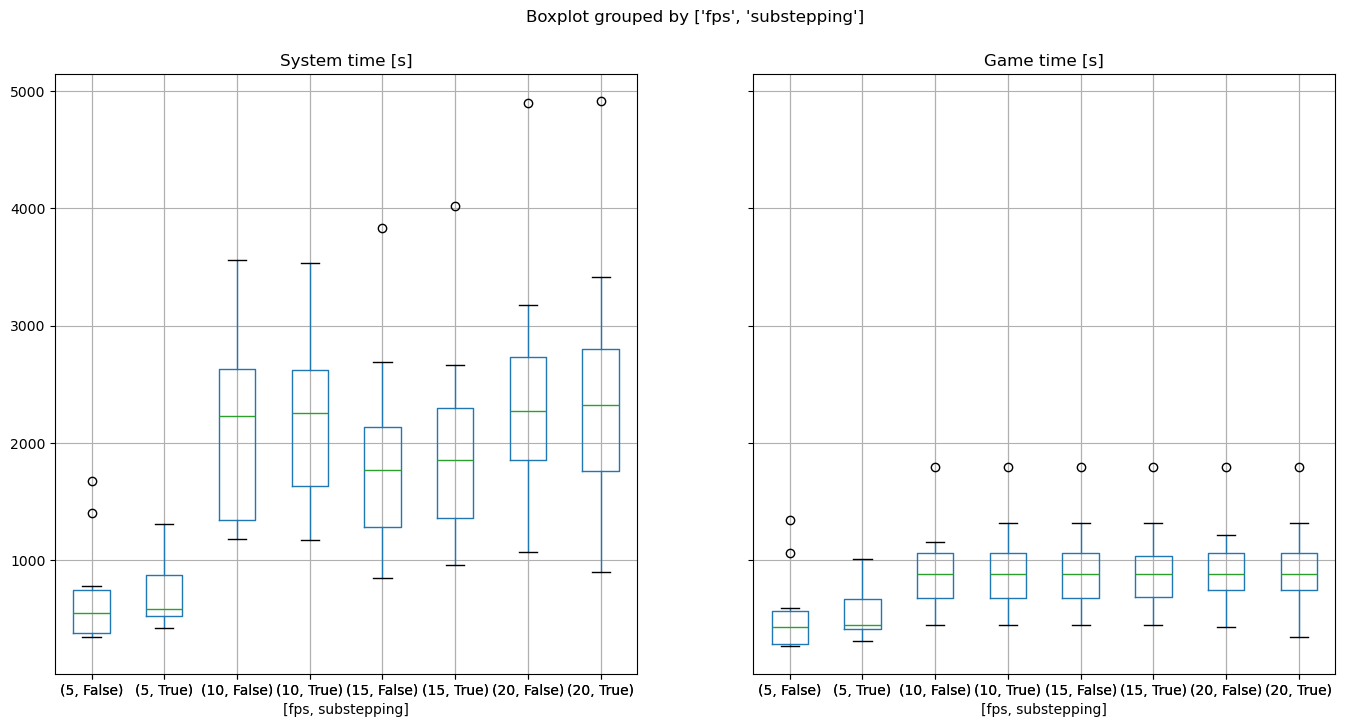

In [233]:
fig, ax = plt.subplots(figsize=(16, 8))

axes = df.boxplot(column=['duration_system', 'duration_game'],
                  by=['fps', 'substepping'], ax=ax)

axes[0].set_title("System time [s]")
axes[1].set_title("Game time [s]")

# plt.tight_layout()

### Conclusions: ?

Experiments need to be repeated?

Importance of isolated hardware?, HPC?, ronin?

Hardware is unrealiable

Other work might affect, working

### Q1.2 Does substepping affect execution time?

/tmp/ipykernel_8217/2355413093.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(column=['duration_system', 'duration_game'],


Text(0.5, 1.0, 'Game time [s]')

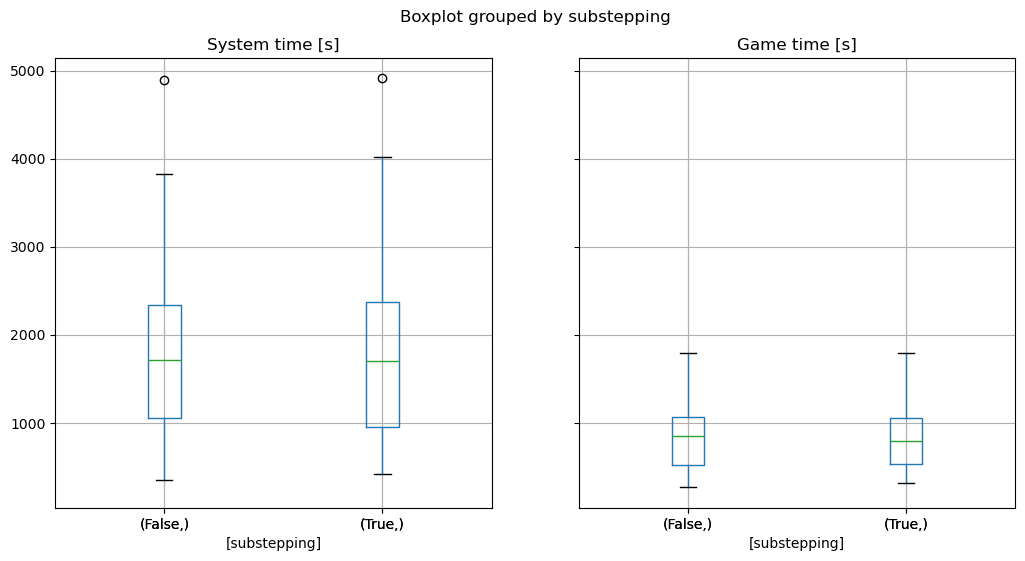

In [240]:
size = 6
fig, ax = plt.subplots(figsize=(size*2, size))

axes = df.boxplot(column=['duration_system', 'duration_game'],
                  by=['substepping'], ax=ax)

axes[0].set_title("System time [s]")
axes[1].set_title("Game time [s]")

In [235]:
df[['duration_system']].groupby('substepping').mean()

,duration_system
substepping,
False,1787.726676
True,1839.460780


$H_0$ the population of all executions with `substepping` is no different to that without `substepping`

In [236]:
def substepping_ttest(column_name):

    substepping_true = df[df.index.get_level_values(
        'substepping') == True][column_name]

    substepping_false = df[df.index.get_level_values(
        'substepping') == False][column_name]

    confidence_level = 0.95
    max_error = 1 - confidence_level

    t_statistic, p_value = scipy.stats.ttest_ind(
        substepping_true, substepping_false)

    print(f"\nFor {column_name = }")
    # print(f"\tT-statistic: {t_statistic}")
    print(f"\tP-value: {p_value}")

    if p_value < max_error:
        print("\tThe difference is statistically significant.")
    else:
        print("\tThe difference is not statistically significant.")

In [237]:


substepping_ttest('duration_system')
substepping_ttest('duration_game')


For column_name = 'duration_system'
	P-value: 0.8266478798730381
	The difference is not statistically significant.

For column_name = 'duration_game'
	P-value: 0.9985278346651925
	The difference is not statistically significant.


### Conclusions: 

substepping doesnt reduce execution time significantly

## Q2: How does fidelity settings affect ADS performance (score_composed, score_penalty, score_route)

/tmp/ipykernel_8217/3498353464.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(column=['score_route', 'score_composed'],


<Axes: title={'center': 'score_penalty'}, xlabel='fps'>

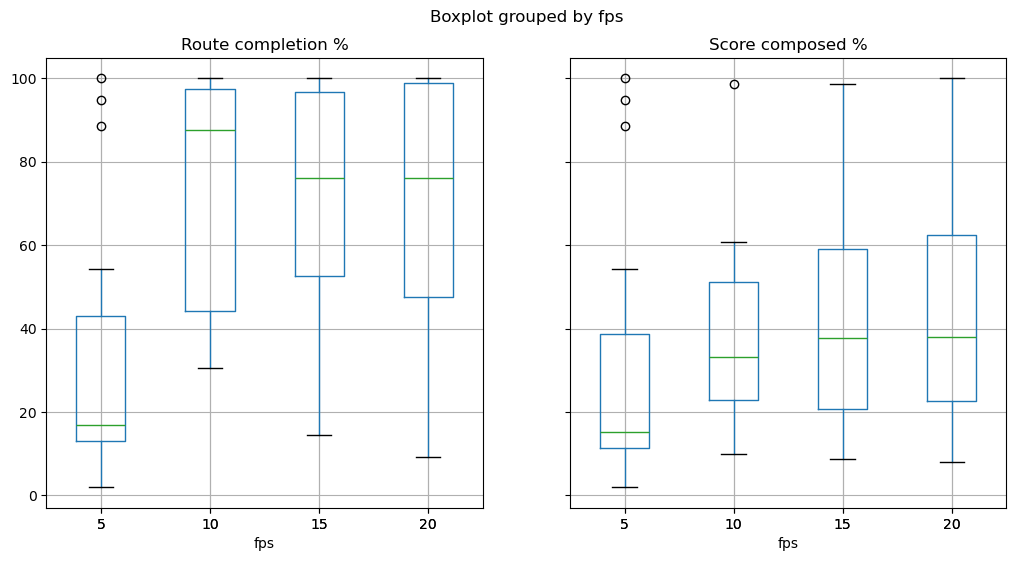

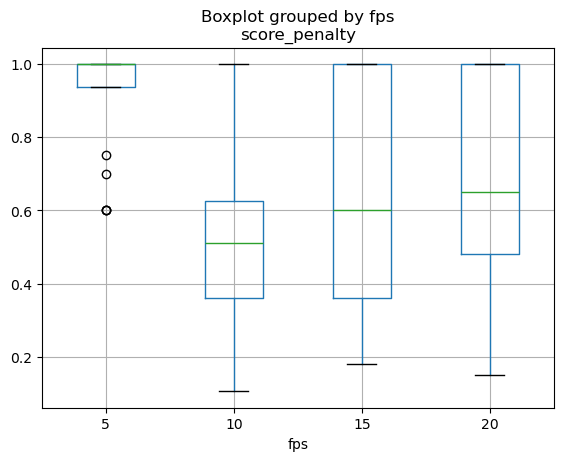

In [238]:
size = 6
fig, ax = plt.subplots(figsize=(size*2, size))

axes = df.boxplot(column=['score_route', 'score_composed'],
                  by='fps', ax=ax)

axes[0].set_title("Route completion %")
axes[1].set_title("Score composed %")


df.boxplot(column=['score_penalty'],
           by='fps')

### Conclusions

Lowering FPS lowers ADS performance

### Q2.2 Does substepping affect ADS performance?

In [239]:
substepping_ttest('score_composed')
substepping_ttest('score_penalty')
substepping_ttest('score_route')


For column_name = 'score_composed'
	P-value: 0.973368887425696
	The difference is not statistically significant.

For column_name = 'score_penalty'
	P-value: 0.9042610357716061
	The difference is not statistically significant.

For column_name = 'score_route'
	P-value: 0.9115053687876347
	The difference is not statistically significant.


### Conclusions

Substepping is completely irrelevant

### post analysis research

![min10FPS.png](imgs/min10FPS.png)